## Imports

In [1]:
import lxml.etree
import healpy as hp
import numpy as np
import pandas as pd
import gcn
import astropy_healpix
import astropy.utils.data
from astropy.coordinates import SkyCoord,concatenate
import astropy.units as u
from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from contours import contour_plots,join_0_360,split_contours,integrated_probability,hpix_contours
from GLADE import GLADEV2coordinates,PS1coordinates
from skymapio import readskymap
import matplotlib.pyplot as plt
from collections import OrderedDict
from astrobase.coordutils import make_kdtree
from astrobase.coordutils import conesearch_kdtree
from matplotlib.patches import Circle
from fields import inside_circle, circ, intersect_2_or_3, split_between_3_overlap, split_between_2_overlap
import fsspec

In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

## Loading the alert

In [2]:
# Load the alert

payload = open('S200129m-3-Initial.xml', 'rb').read()
root = lxml.etree.fromstring(payload)
params = {elem.attrib['name']:
              elem.attrib['value']
              for elem in root.iterfind('.//Param')}

## Read skymap and create x% contours

In [3]:
# get the ID and alert type
graceid=params['GraceID']
prelim=params['AlertType']+params['Pkt_Ser_Num']

# Read the HEALPix sky map and the FITS header.
skymap, prob, distmu, distsigma, distnorm, npix, nside, distest, diststd = readskymap(params['skymap_fits'])

# Get the integrated probability map
csm=integrated_probability(prob)

# Identify the x% contours
contours=hpix_contours(csm,levels=[0.75],nest=False)
levels=[0.75]
levelsper=[75]

## Load GLADE and PS1 sources

In [4]:
# Get all galaxies from GLADE
coordinates1,data=GLADEV2coordinates()

# Get all extended sources from PS1 from Google Drive csv file

coordinates, data1= PS1coordinates('s3://gxgwtest/GW200129m_total1_Lana_S.csv')

# concatenate coordinates of GLADE and PS1 sources
coordinates=concatenate([coordinates1, coordinates])
data = pd.concat([data[['RA','Dec']],data1[['RA','Dec']]])

lengthofdata 1613115


## Crossmatch skymap with sources

In [5]:
# read sky map
url='https://gracedb.ligo.org/api/superevents/'+graceid+'/files/LALInference.multiorder.fits'
skymap=read_sky_map(url, moc=True)

# healpy crossmatch skymap with galaxies
result=crossmatch(skymap,coordinates)

#separate masked array into separate contours
split_dec, split_ra = split_contours(contours, levels[0],0)
split_ra2, split_dec2=join_0_360(split_ra, split_dec)

# just take galaxies within x%
results=data[result.searched_prob<0.99]
ra_incontour=results['RA'].values
dec_incontour=results['Dec'].values

[3.20883768e-04 6.41716087e-04 9.62485699e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
contouridx []
skymap []


## Plot

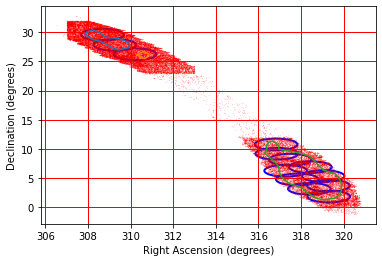

In [6]:
# plot contours and galaxies
plt.figure(1)
plt.plot( ra_incontour, dec_incontour,'r.',markersize=0.1)
for r in range(0,len(split_ra2)):
    plt.plot(split_ra2[r],split_dec2[r],'-')

plt.grid(color='r', linestyle='-', linewidth=1, which='both')

# for 75% contours 200129m, define field centres.
circ_dec=[29.612335710496843, 27.85185949195497, 26.2477161548889, 10.763540991336118, 9.167501620793303, 8.151264218777623, 6.8662698178817685, 6.238286084752751, 4.744062002711146, 5.318412211940824, 3.667265869039902, 3.1433075971002467, 1.8054163965344472]
circ_ra=[308.6869806094183,309.2686980609418,310.21606648199446,316.8310249307479,316.86426592797784,317.4958448753463,318.4432132963989,317.2797783933518,317.82825484764544,319.0415512465374,319.2908587257618,318.393351800554,319.3074792243767]

for k in range(0,len(circ_ra)):
    plt.gca().add_patch(Circle((circ_ra[k],circ_dec[k]),radius=1,linewidth=2,edgecolor='b',facecolor='none'))

plt.ylabel('Declination (degrees)')
plt.xlabel('Right Ascension (degrees)')
plt.show()

## Galaxies in each field

In [7]:
# identify set of galaxies in each field - STOP HERE IF YOU JUST WANT NUM GALAXIES IN EACH FIELD
ra_incirc=[]
dec_incirc=[]
ind_circ=[]
for r in range(0,len(circ_ra)):
    raincirc, decincirc=zip(*[(ra_incontour[d],dec_incontour[d]) for d,(x,y) in enumerate(zip(ra_incontour,dec_incontour)) if circ(ra_incontour[d],dec_incontour[d],circ_dec[r],circ_ra[r])<1 ])
    ind_circ.append([ d for d,(x,y) in enumerate(zip(ra_incontour,dec_incontour)) if circ(ra_incontour[d],dec_incontour[d],circ_dec[r],circ_ra[r])<1 ])
    ra_incirc.append(raincirc)
    dec_incirc.append(decincirc)


## Intersecting fields

In [8]:
# identify fields that intersect with each other
intersec=[]
for x in range(0,len(circ_ra)):
    for f in range(0,len(circ_ra)):
        t = inside_circle(circ_dec[x], circ_ra[x], circ_dec[f], circ_ra[f], 1, 1)  
        if t>=0:
            intersec.append([x, f])

# identify galaxies in overlapping regions
galsintersect=[]
for d in range(0,len(circ_ra)):
    for s in range(0,len(intersec)):
        if d==intersec[s][0] and intersec[s][0]!=intersec[s][1]:
            galsintersect.append([elem for elem in ind_circ[d] if elem in ind_circ[intersec[s][1]]])
        else:
            galsintersect.append([])

# Find intersecting sets of galaxies
intersect_set=[]
for d in range(0,len(circ_ra)):
    for s in range(0,len(intersec)):
        for t in range(0,len(intersec)):
            if d==intersec[s][0] and d==intersec[t][0] and s!=t and intersec[t][0]!=intersec[t][1]:
                if [d, intersec[t][1]] not in intersect_set and [intersec[t][1], d] not in intersect_set:
                    intersect_set.append([d,intersec[t][1]])
                    intersect=set(galsintersect[s]).intersection(set(galsintersect[t]))

# see if there are galaxies that are in overlapping regions
overlapping_regions=[]
for d in range(0,len(circ_ra)):
    result = [i for i in intersect_set if i[0]==d]
    newcross=[]
    for r in range(0,len(result)):
        for e in range(0,len(result)):
            if r!=e:
                crossresult=[i for i in intersect_set if i[0]==result[r][1] and i[1]==result[e][1]]
                if crossresult!=[]:
                    newcross.append(crossresult[0])     
    result.extend(newcross)
    overlapping_regions.append(result)
    
# set of fields that intersect with 2 or 3 others.
twointersectsets, threeintersectsets, twointersectvals, threeintersectvals,threelist = intersect_2_or_3(circ_ra, overlapping_regions, ind_circ)

# remove from list of fields with 2 intersections if there are 3 intersections.
for i in reversed(range(len(twointersectsets))):
    for t in reversed(range(len(twointersectsets[i]))):
        if twointersectsets[i][t] in threelist:
            del twointersectsets[i][t]




## Split sources in overlapping regions between fields

In [9]:
targets=[set(a) for a in ind_circ]
gals_in_one_field=[]

# Identify galaxies that are not in other fields.
for set_element in targets:
    gals_in_one_field.append(set_element.difference(set.union(*[x for x in targets if x is not set_element])))

for d in range(0,len(circ_ra)):
    ra_incirc[d]=[ra_incontour[i] for i in list(gals_in_one_field[d])] 
    dec_incirc[d]=[dec_incontour[i] for i in list(gals_in_one_field[d])] 
    ind_circ[d]=[i for i in list(gals_in_one_field[d])] 

# Split galaxies evenly between overlapping fields.
ra_incirc, dec_incirc, ind_circ = split_between_3_overlap(circ_ra, threeintersectvals, threeintersectsets, ra_incirc, dec_incirc, ind_circ,ra_incontour,dec_incontour)
ra_incirc, dec_incirc, ind_circ = split_between_2_overlap(circ_ra, twointersectvals, twointersectsets, ra_incirc, dec_incirc, ind_circ,ra_incontour,dec_incontour)

for i in range(0,len(ind_circ)):
    print(len(ind_circ[i]), 'sources in field', i+1)


3610 sources in field 1
3248 sources in field 2
3614 sources in field 3
1427 sources in field 4
1486 sources in field 5
1718 sources in field 6
1440 sources in field 7
1153 sources in field 8
1162 sources in field 9
1269 sources in field 10
1256 sources in field 11
1508 sources in field 12
1904 sources in field 13


## How many are within 1'?

In [10]:
# Identify how many are within 1 arcmin of each other
tree=make_kdtree(ra_incontour,dec_incontour)
conesearcheslist=[]
for i in range(0,len(ra_incontour)):
    conesearches=[]
    conesearch=conesearch_kdtree(tree,ra_incontour[i],dec_incontour[i],0.016666667)
    for j in range(0,len(conesearch)):
        if conesearch[j]!=i:
            conesearches.append(conesearch[j])
    conesearcheslist.append(conesearches)

# pairs of galaxies within 1 arcmin
pairs=[]
for i in range(0,len(conesearcheslist)):
    for k in range(0,len(conesearcheslist[i])):
        pairs.append([i,conesearcheslist[i][k]])

# remove reversed duplicates
for i in range(0,len(pairs)):
    pairs[i]=sorted(pairs[i])
newlist=OrderedDict((tuple(x), x) for x in pairs).values()
newlist=list(newlist)

#print(len(newlist),'pairs close to each other')